基于用户不同时间的用电量数据，以聚类的方式可以更好的理解用户用电行为。    
这有利于：  
1.将用电行为类似的用户进行聚合，以便用电公司提供更合理的套餐服务；  
2.根据不同类型的用户行为，收取不同的税费；  
3.根据不同类型的用户行为，调整电网的输电效率；  

本次模拟采用的是K-means聚类方法，数据源自[Pecan Street Energy Database](http://www.pecanstreet.org/)的数据库文件`dataport_sqlite`

## 1.导入数据

In [31]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
import sqlite3

从数据库读取数据

In [32]:
# 从当前路径的数据库文件（dataport_sqlite）读取数据 
cwd = os.getcwd()
conn = sqlite3.connect(str(cwd) + "/dataport_sqlite") 
cursor = conn.cursor()
query = "SELECT * FROM new_table;"
cursor.execute(query)
data = cursor.fetchall()

在pandas中导入数据

In [33]:
loads_df = pd.DataFrame(data, columns=['id','date','energy_use'])
loads_df.head()

,id,date,energy_use
0,26,2015-08-01 00:00:00,1.4090666666666667
1,26,2015-07-31 23:45:00,3.1387333333333333
2,26,2015-07-31 23:30:00,4.2021333333333333
3,26,2015-07-31 23:15:00,4.2418000000000000
4,26,2015-07-31 23:00:00,4.2857333333333333


数据中，id代表不同的用户；date代表时间，每15min采集一次；energy_use代表测量的电量，以kW表示。

In [34]:
#查看数据量
print("当前数据集含有%s行,%s列"%(loads_df.shape[0],loads_df.shape[1]))

当前数据集含有646981行,3列


In [35]:
#由采集数据的结果可知，记录的是15年7月一个月的用电情况
print(" 最早时间: %s \n 最晚时间: %s"%(loads_df.date.min(),loads_df.date.max()))

 最早时间: 2015-07-01 00:00:00 
 最晚时间: 2015-08-01 00:00:00


In [36]:
#查看id，可知不同的用户共有216户
loads_df['id'].value_counts()

3268    2977
3392    2977
2751    2977
3935    2977
370     2977
772     2977
1801    2977
93      2977
3864    2977
2365    2977
1830    2977
1731    2977
3953    2977
2449    2977
2472    2977
2199    2977
1718    2977
1696    2977
267     2977
2378    2977
115     2977
436     2977
1310    2977
1086    2977
1185    2977
3044    2977
4042    2977
114     2977
573     2977
2034    2977
        ... 
3500    2977
3967    2977
364     2977
668     2977
1589    2977
585     2977
1586    2977
2510    2977
3918    2977
2965    2977
2980    2977
604     2977
3506    2977
3723    2977
744     2977
1314    2977
491     2977
2859    2977
2401    2977
171     2977
160     2977
861     2977
275     2977
1617    2977
483     2897
3652    2604
297     1660
490     1447
2974    1188
1508     107
Name: id, Length: 220, dtype: int64

## 2.数据清洗

In [37]:
#查询数据中的空缺值
loads_df = loads_df.replace('',np.nan)
loads_df.isnull().sum() 

id                0
date              0
energy_use    10695
dtype: int64

In [38]:
#删除空缺值
loads_df = loads_df.dropna()
loads_df.shape

(636286, 3)

删除后还有636286行数据

改变数据类型

In [39]:
loads_df.time=loads_df.date.apply(lambda x:x.split( )[1])

D:\Program\Anaconda\envs\py3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


In [40]:
time=loads_df.time.drop_duplicates().sort_values()

In [41]:
loads_df.loc[:,'energy_use'] = loads_df.energy_use.astype(float) 

loads_df.loc[:,'id'] = loads_df['id'].astype(int) 

loads_df.loc[:,'date'] = pd.to_datetime(loads_df.date) 

In [42]:
loads_df.head()

,id,date,energy_use
0,26,2015-08-01 00:00:00,1.409067
1,26,2015-07-31 23:45:00,3.138733
2,26,2015-07-31 23:30:00,4.202133
3,26,2015-07-31 23:15:00,4.241800
4,26,2015-07-31 23:00:00,4.285733


## 3.特征工程

上述数据的时间仅为一列，无法较好的反映工作日与周末及每月具体日期的区别，因此尝试添加列进一步细化日期

In [43]:
# 添加一代表星期的列
loads_df.loc[:,'type_day'] = loads_df.date.apply(lambda x: x.isoweekday()) 

# 添加一代表日期的列
loads_df.loc[:,'day_of_month'] = loads_df.date.apply(lambda x: x.day) 

# 按照id和日期进行重新排序
loads_df = loads_df.sort_values(['id', 'date'], ascending=[True, True])
loads_df = loads_df.reset_index(drop=True)

In [44]:
loads_df.head()

,id,date,energy_use,type_day,day_of_month
0,26,2015-07-01 00:00:00,1.571533,3,1
1,26,2015-07-01 00:15:00,0.871400,3,1
2,26,2015-07-01 00:30:00,1.571933,3,1
3,26,2015-07-01 00:45:00,3.406000,3,1
4,26,2015-07-01 01:00:00,3.417467,3,1


过滤掉周末，以便用户习惯更加一致，便于聚类

In [45]:
loads_df=loads_df[loads_df.type_day<=5]

改变数据结构

In [46]:
#按照日期和时间绘制数据透视表，获得不同时间下的用户用电数据
loads_wide_df = pd.pivot_table(data=loads_df,columns=['date','day_of_month'],values='energy_use',index=['id'])

In [47]:
loads_wide_df.head()

date,2015-07-01 00:00:00,2015-07-01 00:15:00,2015-07-01 00:30:00,2015-07-01 00:45:00,2015-07-01 01:00:00,2015-07-01 01:15:00,2015-07-01 01:30:00,2015-07-01 01:45:00,2015-07-01 02:00:00,2015-07-01 02:15:00,...,2015-07-31 21:30:00,2015-07-31 21:45:00,2015-07-31 22:00:00,2015-07-31 22:15:00,2015-07-31 22:30:00,2015-07-31 22:45:00,2015-07-31 23:00:00,2015-07-31 23:15:00,2015-07-31 23:30:00,2015-07-31 23:45:00
day_of_month,1,1,1,1,1,1,1,1,1,1,...,31,31,31,31,31,31,31,31,31,31
id,,,,,,,,,,,,,,,,,,,,,
26,1.571533,0.871400,1.571933,3.406000,3.417467,2.583333,0.837867,0.790133,0.834733,0.868467,...,4.480667,4.474867,4.574867,4.448933,5.134600,4.505933,4.285733,4.241800,4.202133,3.138733
59,0.986667,0.947133,0.901800,0.896733,1.008133,0.841067,0.915400,0.851467,1.050067,0.872133,...,3.499867,2.251333,3.897800,3.797467,2.279867,3.671600,1.521000,2.790000,2.836133,1.430867
68,0.318400,0.298733,0.250000,0.263667,0.325467,0.263267,0.250000,0.314333,0.318200,0.278733,...,0.218200,0.237733,0.288533,0.286933,0.251200,0.219000,0.236600,0.296800,0.243600,0.224400
77,0.340333,0.442933,0.444133,0.389467,0.406067,0.434400,0.367333,0.391267,0.523733,0.558467,...,2.351200,2.667533,3.279867,1.999000,2.049467,3.172933,1.993067,2.056200,2.950867,0.690400
86,0.208467,0.213467,0.211067,0.250800,0.320533,0.323133,0.310733,0.300333,0.291600,0.230667,...,2.897400,3.641267,1.874733,1.219800,3.598200,1.756267,1.470400,3.479733,0.576800,2.025467


In [48]:
#取10日当天数据进行分析
unique_days = loads_df.day_of_month.unique()
loads_wide_df = pd.concat([loads_wide_df.xs(10,level='day_of_month',axis=1) for day in unique_days])

In [49]:
loads_wide_df=loads_wide_df.drop_duplicates()

In [50]:
loads_wide_df.head()

date,2015-07-10 00:00:00,2015-07-10 00:15:00,2015-07-10 00:30:00,2015-07-10 00:45:00,2015-07-10 01:00:00,2015-07-10 01:15:00,2015-07-10 01:30:00,2015-07-10 01:45:00,2015-07-10 02:00:00,2015-07-10 02:15:00,...,2015-07-10 21:30:00,2015-07-10 21:45:00,2015-07-10 22:00:00,2015-07-10 22:15:00,2015-07-10 22:30:00,2015-07-10 22:45:00,2015-07-10 23:00:00,2015-07-10 23:15:00,2015-07-10 23:30:00,2015-07-10 23:45:00
id,,,,,,,,,,,,,,,,,,,,,
26,3.694933,3.680733,3.647667,2.960200,0.904000,0.971533,1.012333,0.726533,0.447933,1.180933,...,4.637733,4.588600,4.446733,4.064600,4.134000,1.800200,1.329867,1.324867,3.689267,4.055200
59,0.401467,1.703000,0.395267,1.623400,0.541400,0.453933,1.602000,0.352067,1.479800,0.608267,...,2.463000,2.160467,1.007600,1.832400,1.966600,0.608667,1.820000,0.531667,1.580400,0.966733
68,0.131267,0.066000,0.066000,0.108333,0.128667,0.066000,0.068467,0.137200,0.134600,0.076933,...,0.104800,0.065000,0.065800,0.261467,0.256200,0.383533,0.290333,0.327000,0.370667,0.359467
77,0.606733,0.869933,1.350467,1.526400,0.616000,1.605133,0.857800,1.000400,1.499867,0.850867,...,1.499000,2.876733,2.173400,1.029733,1.634467,2.302467,1.919933,0.778267,1.481867,1.614133
86,0.332667,0.335200,0.266933,0.237467,0.239800,0.240400,0.358467,0.363000,0.344200,0.335533,...,1.697933,0.849067,2.865000,0.626867,5.820600,7.699733,6.080067,3.346133,2.249800,0.834000


### Let's check if some households have missing measurements 

In [51]:
#查看缺失值，其中T代表将原有矩阵转置
loads_wide_df.T.isnull().sum().sort_values(ascending=False).head()

id
1508    96
1283     0
1507     0
1500     0
1463     0
dtype: int64

可见，用户1508缺失所有用电数据，可以将其删除

In [52]:
loads_wide_df = loads_wide_df.dropna(axis=0,how='any')

In [53]:
print('删除空值列后，当前数据集有%s行，%s列'%(loads_wide_df.shape[0],loads_wide_df.shape[1]))

删除空值列后，当前数据集有215行，96列


In [54]:
loads_wide_df.head()

date,2015-07-10 00:00:00,2015-07-10 00:15:00,2015-07-10 00:30:00,2015-07-10 00:45:00,2015-07-10 01:00:00,2015-07-10 01:15:00,2015-07-10 01:30:00,2015-07-10 01:45:00,2015-07-10 02:00:00,2015-07-10 02:15:00,...,2015-07-10 21:30:00,2015-07-10 21:45:00,2015-07-10 22:00:00,2015-07-10 22:15:00,2015-07-10 22:30:00,2015-07-10 22:45:00,2015-07-10 23:00:00,2015-07-10 23:15:00,2015-07-10 23:30:00,2015-07-10 23:45:00
id,,,,,,,,,,,,,,,,,,,,,
26,3.694933,3.680733,3.647667,2.960200,0.904000,0.971533,1.012333,0.726533,0.447933,1.180933,...,4.637733,4.588600,4.446733,4.064600,4.134000,1.800200,1.329867,1.324867,3.689267,4.055200
59,0.401467,1.703000,0.395267,1.623400,0.541400,0.453933,1.602000,0.352067,1.479800,0.608267,...,2.463000,2.160467,1.007600,1.832400,1.966600,0.608667,1.820000,0.531667,1.580400,0.966733
68,0.131267,0.066000,0.066000,0.108333,0.128667,0.066000,0.068467,0.137200,0.134600,0.076933,...,0.104800,0.065000,0.065800,0.261467,0.256200,0.383533,0.290333,0.327000,0.370667,0.359467
77,0.606733,0.869933,1.350467,1.526400,0.616000,1.605133,0.857800,1.000400,1.499867,0.850867,...,1.499000,2.876733,2.173400,1.029733,1.634467,2.302467,1.919933,0.778267,1.481867,1.614133
86,0.332667,0.335200,0.266933,0.237467,0.239800,0.240400,0.358467,0.363000,0.344200,0.335533,...,1.697933,0.849067,2.865000,0.626867,5.820600,7.699733,6.080067,3.346133,2.249800,0.834000


依据当前结果，绘制当日不同时间不同用户的用电特征曲线

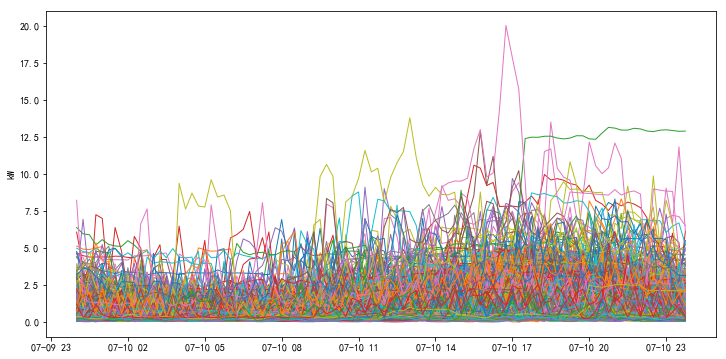

In [55]:
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(loads_wide_df.T,alpha=1,lw=1)
plt.ylabel('kW')
plt.show()

额，杂乱无章，完全看不出规律，下面我们将当前获得的数据进行聚类

## 4.聚类模型

In [214]:
from sklearn.cluster import KMeans

class EnergyFingerPrints():
     
    def __init__(self,data):
        # will contain the centroid of each cluster
        self.means = [] 
        self.data = data

    def elbow_method(self,n_clusters):
        """Performs elbow method for a predefined number
        of clusters.
        
        Parameters
        ----------
        n_clusters : int
            the number of clusters to perform the elbow method
        
        Returns
        ---------
        A plot the of elbow method
        """
        fig,ax=plt.subplots(figsize=(8,4)) 
        distortions = []

        for i in range(1, n_clusters):
            km = KMeans(n_clusters = i, 
                        init='k-means++', #初始中心簇的获取方式，k-means++一种比较快的收敛的方法
                        n_init=10,        #初始中心簇的迭代次数
                        max_iter=300,     #数据分类的迭代次数
                        random_state=0)   #初始化中心簇的方式
            km.fit(self.data)
            distortions.append(km.inertia_) #inertia计算样本点到最近的中心点的距离之和
        
        plt.plot(range(1,n_clusters), distortions, marker='o',lw=1)
        plt.xlabel('聚类数量')
        plt.ylabel('至中心点距离之和')
        plt.show() 
        
    def get_cluster_counts(self):
        return pd.Series(self.predictions).value_counts()
    
    def labels(self,n_clusters):
        self.n_clusters = n_clusters
        return KMeans(self.n_clusters, init='k-means++', n_init=10,max_iter=300,random_state=0).fit(self.data).labels_
        
    def fit(self,n_clusters):
        """Performs K-means clustering for the load-profiles
        
        Parameters
        ----------
        n_clusters : int
        
        Returns
        --------
        count_dict : dict
            The number of load-profiles in each cluster
        """
        self.n_clusters = n_clusters
        self.kmeans = KMeans(self.n_clusters)
        self.predictions = self.kmeans.fit_predict(self.data)

    def plot(self):
        """Plots all loads in each cluster"""
        
        self.cluster_names = [str(x) for x in range(self.n_clusters)]
        fig,ax=plt.subplots(figsize=(12,16))

        for i in range(0,self.n_clusters):
            all_data = [] 
            for x,y in zip(self.data,self.predictions):
                    if y == i:
                        all_data.append(x)
                        plt.subplot(4,1,i+1)
                        plt.plot(x,alpha=0.06,color="blue",lw=2)
                        #plt.ylim(0,4)
                        plt.xlim(0,96)
                        plt.title('Cluster%s'%(i+1))
                        plt.ylabel('用电量/kW')
                    
            all_data_array = np.array(all_data)
            mean = all_data_array.mean(axis=0)
            self.means.append(mean)
            plt.plot(mean, color="black",linewidth=4)
        
        plt.show()
        
    def plot_energy_fingerprints(self):
        """Plots the mean of each cluster in single plot"""
        fig,ax=plt.subplots(figsize=(8,5))
        
        for i,item in enumerate(self.means):
            plt.plot(item, label = "cluster %s"%(str(i+1)))
            plt.xlim(0,96)
        plt.ylabel('用电量/kW')
        plt.xticks([0,20,40,60,80],['00:00','05:00','10:00','15:00','20:00'],rotation=60)
        plt.grid()
        plt.legend()
        plt.show()

## 5.聚类分析

In [215]:
load_data=np.array(loads_wide_df)

导入数据，生成计算模型

In [216]:
energy_clusters = EnergyFingerPrints(load_data)

计算聚类簇的距离

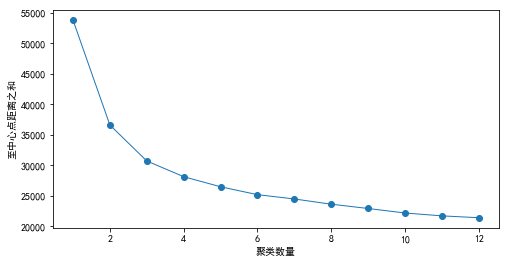

In [217]:
energy_clusters.elbow_method(n_clusters=13)

显然，随着聚类簇数n的增加，样本点至中心簇间的距离逐渐减小。  
这里，我们取n=4为拐点。

构建模型

In [218]:
energy_clusters.fit(n_clusters = 4)

模型结果分组

In [219]:
energy_clusters.get_cluster_counts()

3    87
0    85
2    36
1     7
dtype: int64

In [220]:
group=energy_clusters.labels(n_clusters = 4)

In [221]:
num=loads_wide_df.index

In [222]:
cls=pd.DataFrame(list(num))
cls['cluster']=list(group)
cls.columns=['user_id','cluster']

In [223]:
#通过排序可以得到每个类中的用户id
cls=cls.sort_values(by='cluster',ascending=True)
cls.reset_index(drop=True)

,user_id,cluster
0,2034,0
1,2769,0
2,2751,0
3,2667,0
4,2606,0
5,2401,0
6,2378,0
7,2337,0
8,2207,0
9,2199,0


In [224]:
#获得属于第一分类簇的用户id
np.array(cls.loc[cls.cluster ==0].user_id)

array([2034, 2769, 2751, 2667, 2606, 2401, 2378, 2337, 2207, 2199, 2075,
       4031, 1879, 1832, 1766, 1731, 1586, 1577, 1524, 1500, 1450, 1415,
       1350, 1334, 1310, 1192, 2829, 2859, 2907, 2945, 4022, 3938, 3935,
       3886, 3873, 3864, 3831, 3829, 3778, 3687, 3678, 3631, 1169, 3538,
       3482, 3443, 3413, 3368, 3299, 3268, 3224, 3104, 3036, 2992, 2965,
       2953, 3531, 1103, 4042,  624,  267,  410,  645,  436,  203,  575,
        457,  171,  470,  160,  130,  297,  573,  547,  772,  739,  507,
        115,  491,   94,  871,   68,  516,  954,  936], dtype=int64)

In [225]:
#获得属于第二分类簇的用户id
np.array(cls.loc[cls.cluster ==1].user_id)

array([ 364, 3039, 2641, 3009,  499, 2986, 2818, 2814, 2931, 2742, 2864,
        484, 2755, 2787, 2980, 3134, 2710,  275,   59, 3967,   77, 3893,
         86,   93, 3849,  101,  114, 3736, 3723, 3721, 3719,  121, 3649,
       3577, 3527, 3510, 3506, 3456,  232, 3392, 2638, 3310, 3273, 3192,
       2575,   26, 2532, 1953, 1403, 1947,  781, 1463,  585,  744,  668,
       1830,  661, 1800, 1792, 1617, 2557, 1629, 1632, 1714, 1642, 1700,
       1681,  580, 2004,  946,  994, 1086, 2470, 2461, 2449, 2365, 2361,
       1392, 1696, 2158, 2072,  821, 2171,  861, 1314, 2156,  890], dtype=int64)

In [226]:
#获得属于第三分类簇的用户id
np.array(cls.loc[cls.cluster ==2].user_id)

array([ 187, 3918, 3635, 1589, 3953, 3652, 1185, 1283, 3795,  252, 1697,
        503, 2472,  545,  490, 2335, 2242, 2233,  483, 2925, 2129, 2094,
        434, 3500,  370,  974, 3092,  222, 3221, 1801, 1718, 1791, 3044,
       1790, 3367], dtype=int64)

In [227]:
#获得属于第四分类簇的用户id
np.array(cls.loc[cls.cluster ==3].user_id)

array([3401, 3394, 3916,  604, 1507, 3126, 1202, 2018], dtype=int64)

各组用电数据曲线对比

D:\Program\Anaconda\envs\py3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


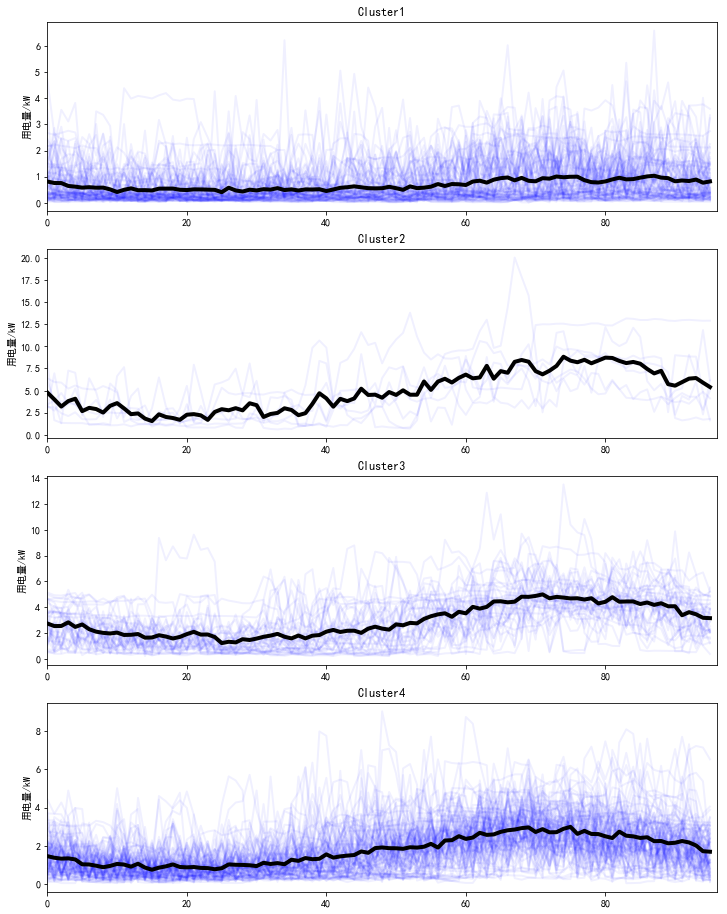

In [228]:
energy_clusters.plot()

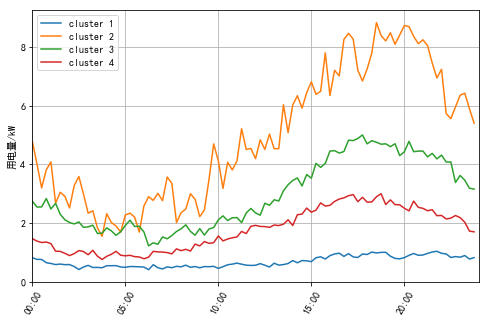

In [229]:
energy_clusters.plot_energy_fingerprints()